

*   In this project, I use Meta-learning and Graph neural network to solve the sum rate maximization problem under the quality of service constraints.
*   The channel state information (CSI) follows geometry distribution
*   The incorporation of meta-learning and GNN provides an improvement in term of generalization of model

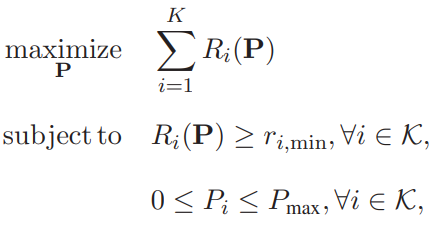







Generate a feasible dataset


*   I generated 50k feasible datapoints for training and 10k for testing




[Procedure to check the feasibility of the rate constraints](https://ieeexplore.ieee.org/document/4801507?arnumber=4801507)

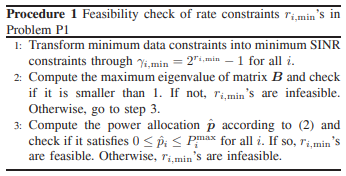

In [ ]:
def generate_geometry_CSI(K, num_H, rng, area_length=10, alpha=3):
    tx_pos = np.zeros([num_H, K, 2])
    rx_pos = np.zeros([num_H, K, 2])
    rayleigh_coeff = np.zeros([num_H, K, K])
    for i in range(num_H):
        tx_pos[i, :, :] = rng.rand(K, 2) * area_length
        rx_pos[i, :, :] = rng.rand(K, 2) * area_length
        rayleigh_coeff[i, :, :] = (
            np.square(rng.randn(K, K)) + np.square(rng.randn(K, K))) / 2

    tx_pos_x = np.reshape(tx_pos[:, :, 0], [num_H, K, 1]) + np.zeros([1, 1, K])
    tx_pos_y = np.reshape(tx_pos[:, :, 1], [num_H, K, 1]) + np.zeros([1, 1, K])
    rx_pos_x = np.reshape(rx_pos[:, :, 0], [num_H, 1, K]) + np.zeros([1, K, 1])
    rx_pos_y = np.reshape(rx_pos[:, :, 1], [num_H, 1, K]) + np.zeros([1, K, 1])
    d = np.sqrt(np.square(tx_pos_x - rx_pos_x) +
                np.square(tx_pos_y - rx_pos_y))
    G = np.divide(1, 1 + d**alpha)
    G = G * rayleigh_coeff
    return np.sqrt(np.reshape(G, [num_H, K ** 2]))

def check_feasibility(batch_absH_2, min_snrs, noise_power): # absH_2 means |H|^2
    user_num = np.size(min_snrs)
    batch_size = np.size(batch_absH_2, 0)
    check_mat = np.zeros([batch_size, user_num, user_num])
    for i in range(user_num):
        check_mat[:, i, :] = min_snrs[i]*batch_absH_2[:, :, i] / batch_absH_2[:, i:i+1, i]
        check_mat[:, i, i] = 0

    eig_value, _ = np.linalg.eig(check_mat)
    eig_value *= (np.imag(eig_value) == 0)
    eig_value = np.real(eig_value)
    max_eig = np.max(eig_value, axis=1)

    feasible_flag = np.zeros(batch_size, dtype=bool)
    min_used_power = np.zeros([batch_size, user_num])
    for i in range(batch_size):
        if max_eig[i] > 1:
            continue

        absH_2 = batch_absH_2[i, :, :]
        u = np.divide(min_snrs, np.diag(absH_2)) * noise_power
        u = np.reshape(u, [user_num, 1])
        P = np.matmul(np.linalg.inv(np.identity(user_num) - check_mat[i,:,:]), u)
        P = np.reshape(P, [user_num])
        if np.sum(P<0)>0 or np.sum(P>1)>0:
            continue

        feasible_flag[i] = True
        min_used_power[i, :] = P
    return feasible_flag, min_used_power

while (valid_data_sample_num < sample_num):
        batch_abs_H = generate_geometry_CSI(K , num_H = batch_size, rng = rng, area_length = area_length, alpha = 3)
        feasible_flag, _ = check_feasibility(np.reshape(np.square(batch_abs_H), [batch_size, K, K]), 2**min_rates - 1, noise_power)
        num_feasible_sample = sum(feasible_flag)
        print(num_feasible_sample)
        if num_feasible_sample == 0:
            continue

        batch = np.append(batch, batch_abs_H[feasible_flag, :], axis = 0)
        batch = batch.astype(np.float32)
        valid_data_sample_num += num_feasible_sample

Install Torch geometric

In [ ]:
import torch
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric

Import neccessary packages

In [ ]:
import math
import numpy as np
import scipy.io as sio  
import torch.nn.functional as F
import time
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, BatchNorm1d as BN

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Utility Functions

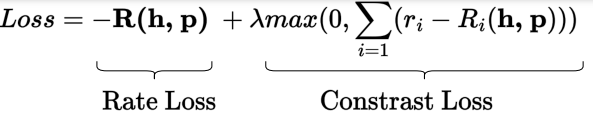

In [ ]:
def np_sum_rate(H,p,alpha,var_noise):
    H = np.expand_dims(H,axis=-1)
    K = H.shape[1]
    N = H.shape[-1]
    p = p.reshape((-1,K,1,N))
    rx_power = np.multiply(H, p)
    rx_power = np.sum(rx_power,axis=-1)
    rx_power = np.square(abs(rx_power))
    mask = np.eye(K)
    valid_rx_power = np.sum(np.multiply(rx_power, mask), axis=1)
    interference = np.sum(np.multiply(rx_power, 1 - mask), axis=1) + var_noise
    rate = np.log2(1 + np.divide(valid_rx_power, interference))
    w_rate = np.multiply(alpha,rate)
    sum_rate = np.mean(np.sum(w_rate, axis=1))
    return sum_rate

def get_per_user_rate(power, abs_H, noise_power, K):  # return rates of each user for each sample in the batch
        abs_H = torch.reshape(abs_H, [-1, K, K])
        abs_H_2 = torch.square(abs_H).to(device)
        rx_power = torch.multiply(abs_H_2, torch.reshape(power, [-1, K, 1])).to(device)
        mask = torch.eye(K).to(device)
        valid_rx_power = torch.sum(torch.multiply(rx_power, mask), axis=1)
        interference = torch.sum(torch.multiply(rx_power, 1-mask), axis=1) + noise_power
        per_user_rate = torch.log2(1 + torch.divide(valid_rx_power, interference))
        return per_user_rate

def rate_loss(data, out, K):
    power = out[:,1]
    power = torch.reshape(power, (-1, K, 1)) 
    abs_H = data.y
    abs_H_2 = torch.pow(abs_H, 2)  
    rx_power = torch.mul(abs_H_2, power)
    mask = torch.eye(K)
    mask = mask.to(device)
    valid_rx_power = torch.sum(torch.mul(rx_power, mask), 1)
    interference = torch.sum(torch.mul(rx_power, 1 - mask), 1) + noise_power
    rate = torch.log2(1 + torch.div(valid_rx_power, interference))
    sum_rate = torch.mean(torch.sum(rate, 1))
    loss = torch.neg(sum_rate)
    return loss

def constraint_loss(power, abs_H, noise_power, minrates, K):
        abs_H =torch.reshape(abs_H, [-1, K, K])
        abs_H_2 = torch.square(abs_H).to(device)
        rx_power = torch.multiply(abs_H_2, torch.reshape(power, [-1, K, 1])).to(device)
        mask = torch.eye(K).to(device)
        valid_rx_power = torch.sum(torch.multiply(rx_power, mask), axis=1)
        interference = (torch.sum(torch.multiply(rx_power, 1 - mask), axis=1) + noise_power).to(device)
        out = torch.nn.ReLU()
        penalty = 2 ** ((minrates.clone().detach().requires_grad_(True)).to(device)) - 1 - torch.divide(valid_rx_power, interference)
        penalty = out(penalty)
        loss = torch.mean(torch.sum(penalty, axis = 1))
        return loss

# Build graph
def Adjecency_matrix(n):
    adj = []
    for i in range(0,n):
        for j in range(0,n):
            if(not(i==j)):
                adj.append([i,j])
    return adj

def build_graph(H,adj, K):
    n = H.shape[0]
    x1 = np.expand_dims(np.diag(H),axis=1)
    x3 = np.ones((K,1))
    edge_attr = []
    
    x = np.concatenate((x1,x3),axis=1)
    for e in adj:
        edge_attr.append([H[e[0],e[1]],H[e[1],e[0]]])
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(adj, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    y = torch.tensor(np.expand_dims(H,axis=0), dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index.t().contiguous(),edge_attr = edge_attr, y = y)
    return data 

def proc_data(HH, K):
    n = HH.shape[0]
    data_list = []
    cg = Adjecency_matrix(K)
    for i in range(n):
        data = build_graph(HH[i],cg, K)
        data_list.append(data)
    return data_list

# Training and testing procedure

def train(train_loader, user, minrates):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss1 = rate_loss(data,out,user)
        loss2 = constraint_loss(out[:,1], data.y, noise_power, minrates, user)
        loss = loss1 + constraint_loss_scale*loss2
        loss.backward()
        #total_loss += loss.item() * data.num_graphs
        optimizer.step()

def test(test_loader, K):
    total_loss = 0
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            user_rate = get_per_user_rate(out[:, 1], data.y, noise_power, K).cpu().detach().numpy()
            feasible_flag = np.sum(user_rate < rates.cpu().detach().numpy(), axis=1) == 0
            user_rate[~feasible_flag, :] = np.array([0.0, 0.0, 0.0, 0.0])#np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#np.array([0.0, 0.0, 0.0, 0.0])#np.array([0.0, 0.0, 0.0, 0.0, 0.0]) #np.array([0.0, 0.0, 0.0])
            hit_rate = np.sum(feasible_flag) / ntest

            loss = np.mean(np.sum(user_rate, axis=1))
            total_loss += loss.item() * data.num_graphs
            total = total_loss / ntest
    return total, hit_rate

Model

*   This section is inspired by [this repo](https://github.com/yshenaw/GNN-Resource-Management/blob/master/D2D/Gaussian/unweighted.py)




In [ ]:

class MPGNN(MessagePassing):
    def __init__(self, mlp1, mlp2, **kwargs):
        super(MPGNN, self).__init__(aggr='sum', **kwargs)

        self.mlp1 = mlp1
        self.mlp2 = mlp2

    def reset_parameters(self):
        reset(self.mlp1)
        reset(self.mlp2)
        
    def update(self, aggr_out, x):
        tmp = torch.cat([x, aggr_out], dim=1)
        comb = self.mlp2(tmp)
        return torch.cat([x[:,:1], comb],dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        edge_attr = edge_attr.unsqueeze(-1) if edge_attr.dim() == 1 else edge_attr
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        tmp = torch.cat([x_i, x_j, edge_attr], dim=1)
        #tmp = torch.cat([x_j, edge_attr], dim=1)
        agg = self.mlp1(tmp)
        return agg

    def __repr__(self):
        return '{}(nn={})'.format(self.__class__.__name__, self.mlp1,self.mlp2)


def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i], bias = True), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class IGCNet(torch.nn.Module):
    def __init__(self):
        super(IGCNet, self).__init__()

        #self.mlp1 = MLP([4, 128, 64])
        self.mlp1 = MLP([6, 128, 64])
        self.mlp2 = MLP([66, 32, 16])
        self.mlp2 = Seq(*[self.mlp2,Seq(Lin(16, 1, bias = True), Sigmoid())])
        self.conv = MPGNN(self.mlp1,self.mlp2)

    def forward(self, data):
        x0, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index
        x1 = self.conv(x = x0, edge_index = edge_index, edge_attr = edge_attr)
        out = self.conv(x = x1, edge_index = edge_index, edge_attr = edge_attr)
        return out

Meta learning: [Reptile algorithm](https://arxiv.org/abs/1803.02999)

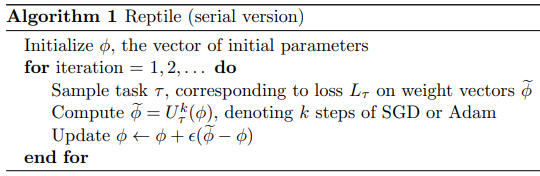

In [ ]:
# Hyperparameters
niterations = 1400
innerepochs = 10
learning_rate = 0.0008
ntest = 10000
tx_snr = 50
noise_power = 10**(-tx_snr/10.0)
outerstepsize = 0.01
constraint_loss_scale = 200
num_user = [3, 4, 6]
rate3 = torch.tensor([0.5, 0.5, 0.5])
rate4 = torch.tensor([0.5, 0.5, 0.5, 0.5])
rate6 = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
min_rates = [rate3, rate4, rate6]

In [ ]:
from copy import deepcopy
import time
train_seed = 1
rng = np.random.RandomState(train_seed)
print('CUDA:', torch.device("cuda" if torch.cuda.is_available() else "cpu"))

model = IGCNet().to(device)

print(time.ctime(time.time()))

# Outer loop
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())

    # Randomly choose a task
    index = rng.permutation(len(all_training_data))
    distribution = np.random.choice(index)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Inner loop
    for _ in range(innerepochs):
        train(all_training_data[distribution], num_user[distribution], min_rates[distribution])

    # Update model's parameters
    weights_after = model.state_dict()
    model.load_state_dict(
        {name: weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize for name in
         weights_before})
    
    # Print out result for K = 3
    if iteration == 0 or (iteration + 1) % 5 == 0:
        print('Iteration: ', iteration)
        total_loss = 0
        for data in X3_test_loader:
          data = data.to(device)
          with torch.no_grad():
            out_power = model(data)
            userrate = get_per_user_rate(out_power[:, 1], data.y, noise_power, K =3).cpu().detach().numpy()
            flag = np.sum(userrate < min_rates[0].cpu().detach().numpy(), axis=1) == 0
            userrate[~flag, :] = np.array([0.0, 0.0, 0.0])
            hit_rate = np.sum(flag) / ntest

            loss = np.mean(np.sum(userrate, axis=1))
            total_loss += loss.item() * data.num_graphs
            total = total_loss / ntest
        print('Sum rate (bits/s/Hz): {: .4f}, Hit rate: {: .4f}'.format(total, hit_rate))


Train base models

In [ ]:
model = IGCNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
# TODO
# Replace train_loader, test_loader by your train and test data
for epoch in range(training_epochs):
    loss1 = train(train_loader, K, rates)
    if epoch == 0 or ((epoch+1) % 5 == 0):
        loss2, _ = test(test_loader, K)
        print('Epoch {:03d}, Val Loss: {:.4f}'.format(epoch, loss2))


Result

Adaptation

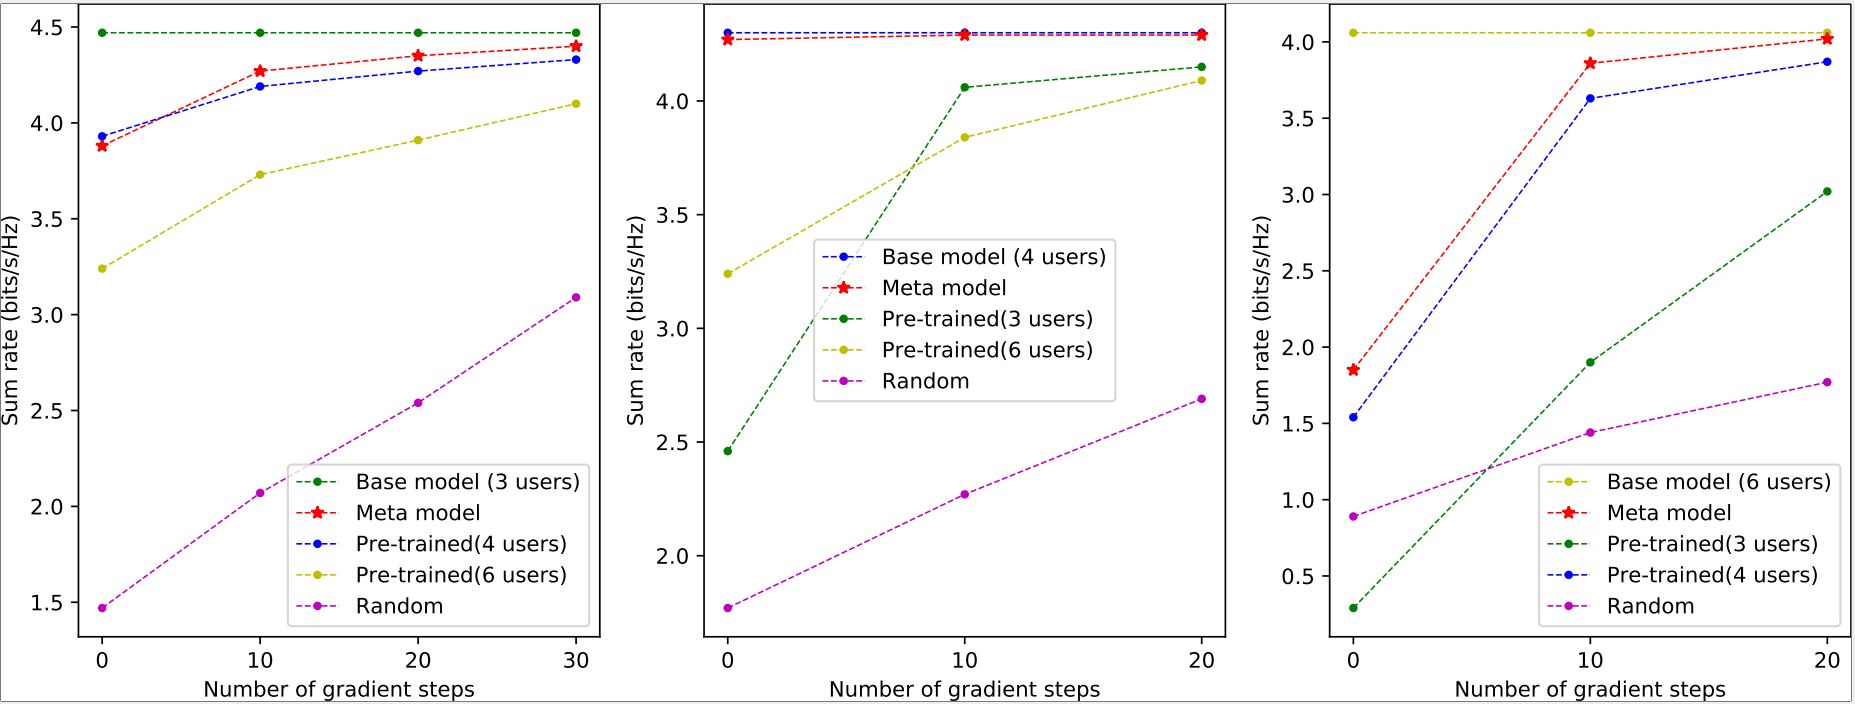

learning a new task

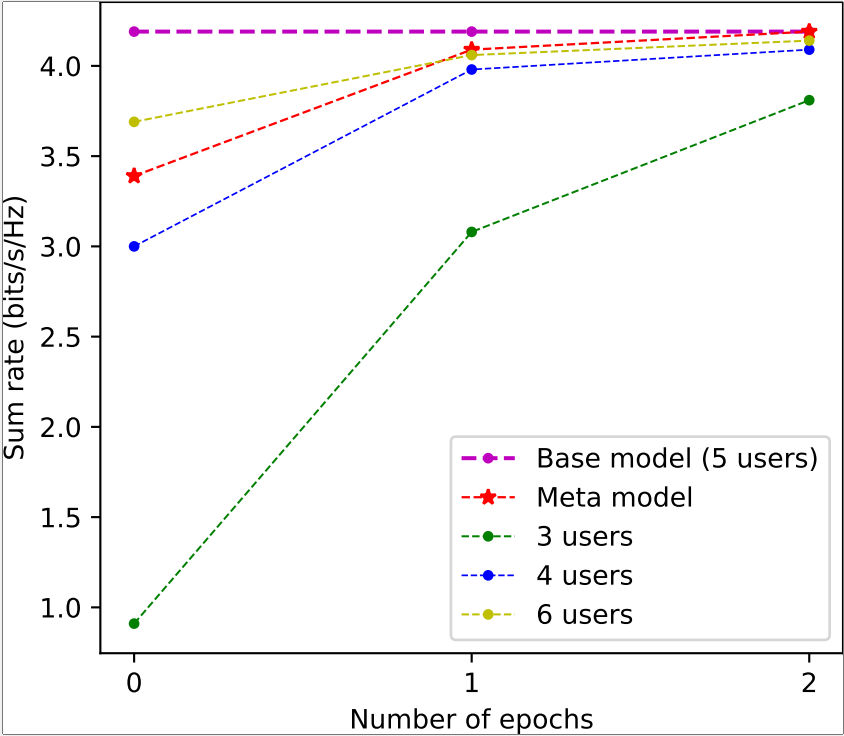

Comparison between 2 ways of updating hidden states

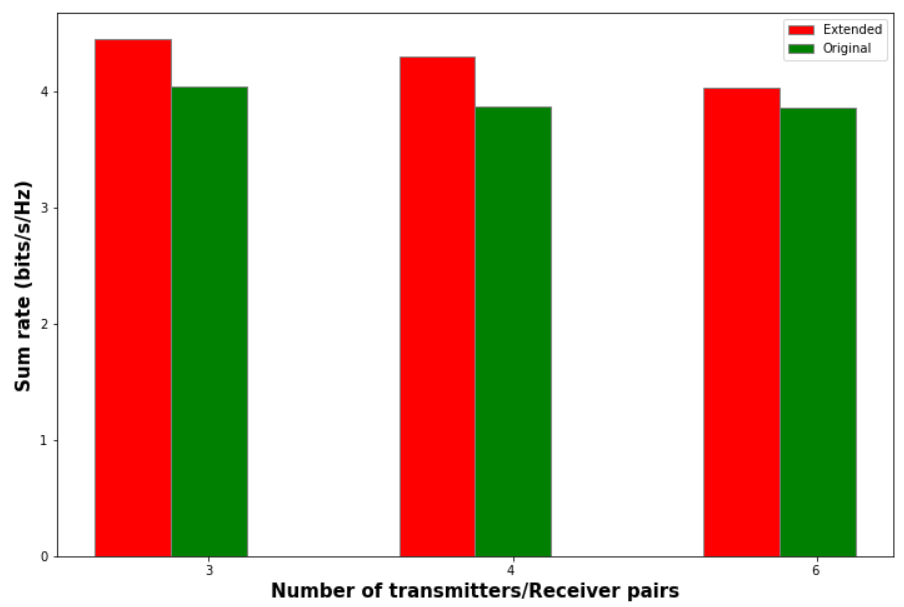